# Performance of different feature combinations for nested training data

This scripts re-loads the classifiers and visualizes their preformance in a ROI x threshold space

### import modules

In [1]:
%matplotlib inline

In [2]:
import os
import fnmatch

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn import preprocessing, model_selection, metrics

import pickle

Initialize a Labeler, which allows to switch from string labels (e.g. "left" to integer labels e.g. 0 and back).

In [3]:
myLabeler = pickle.load(open('../models/myLabeler.p', 'rb'))

divide into training and test data

In [4]:
my_train = pickle.load(open('../models/my_nest.p', 'rb'))

### fit the classifier to the training data

In [5]:
def makeFit(X_train, y_train):

    scaler = preprocessing.StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    clf = SVC(kernel='linear', C=1.0, probability=True, random_state=0)
    clf.fit(X_train_std, y_train)

    return clf, scaler

Example:

In [6]:
X, y = np.array([0., 1., 0., 1.]).reshape(-1, 1), np.array([0, 1, 2, 3])

In [7]:
clf, scaler = makeFit(X, y)

### use the classifier to predict the left-out validation data

In [8]:
def makeYPreds(X_validate, clf, scaler, myLabeler=myLabeler):

    y_pred = []

    for x in X_validate:

        # when there is no LI, we consider the case to be inconclusive
        if np.isnan(x).any():
            pred = myLabeler.transform(['inconclusive'])[-1]

        # otherwise we apply the acutal classifier
        else:
            scaledX = scaler.transform(x.reshape(1, -1))
            pred = clf.predict(scaledX)[-1]

        y_pred.append(pred)

    return np.array(y_pred)

In [9]:
y_pred = makeYPreds(X, clf, scaler)

In [10]:
print y_pred

[2 3 2 3]


### get confusion matrix from prediction of testing data

In [11]:
def makeCm(X_validate, y_validate, y_pred, clf, scaler, myLabeler=myLabeler):

    # predictions of left-out data
    y_pred = makeYPreds(X_validate, clf, scaler)
    # confusion matrix -- input y and y_pred -- result: true in rows, pred in columns
    cm = metrics.confusion_matrix(y_validate, y_pred)

    # put into df
    cmDf = pd.DataFrame(cm)

    # get the naming right
    try:
        theseLabels = myLabeler.inverse_transform(np.unique(y_validate))
        cmDf.index = theseLabels
        cmDf.columns = theseLabels
    except:
        theseLabels = myLabeler.classes_
        cmDf.index = theseLabels
        cmDf.columns = theseLabels

    # make better order
    theseLabels = ['left', 'bilateral', 'right', 'inconclusive']
    cmDf = cmDf.reindex(index=theseLabels)
    cmDf = cmDf.reindex(columns=theseLabels)

    cmDf.index = [['True label'] * cmDf.shape[0], theseLabels]
    cmDf.columns = [['Predicted label'] * cmDf.shape[1], theseLabels]

    return cmDf

In [12]:
cmDf = makeCm(X, y, y, clf, scaler)

In [13]:
cmDf

Predicted label                             
                                   left bilateral right inconclusive
True label left                       1         0     0            0
           bilateral                  1         0     0            0
           right                      0         0     1            0
           inconclusive               0         0     1            0

### scale confusion matrix by total number of cases

In [14]:
def makeScaleCm(cmDf):
    return (cmDf.astype(float).T / cmDf.sum(axis=1)).T

In [15]:
cmScaleDf = makeScaleCm(cmDf)

In [16]:
cmScaleDf

Predicted label                             
                                   left bilateral right inconclusive
True label left                     1.0       0.0   0.0          0.0
           bilateral                1.0       0.0   0.0          0.0
           right                    0.0       0.0   1.0          0.0
           inconclusive             0.0       0.0   1.0          0.0

sanity check: true labels for each class should add up to one

In [17]:
cmScaleDf.T.sum()

True label  left            1.0
            bilateral       1.0
            right           1.0
            inconclusive    1.0
dtype: float64

### get diagonal (correct answers only)

In [18]:
def makeDiagCm(cmDf, idx):

    # get diagonal
    diagDf = pd.DataFrame(np.diagonal(cmDf)).T
    diagDf.index = idx
    diagDf.columns = cmDf.columns

    return diagDf

In [19]:
diagDf = makeDiagCm(cmDf, [['diag'], [0]])

In [20]:
diagDf

Predicted label                             
                  left bilateral right inconclusive
diag 0               1         0     1            0

### get accuracy from diagonal

In [21]:
def getAcc(cmDf, drop=True):

    # get absolute count of hits (diagonal)
    n_diag = makeDiagCm(cmDf, [['total'], ['total']]).sum(axis=1).values[-1]

    # get absolute count of all test data
    n_total = cmDf.sum().sum()

    # get proportion
    prop = n_diag / float(n_total)

    return pd.DataFrame([prop], index=['acc']).T

In [22]:
getAcc(cmDf, drop=True)

,acc
0,0.5


### sort accuracies by percentiles

To now be able to select the best-performing parameters for prediction, we get the percentile of best accuracy for each cell of the accDf table

In [23]:
from scipy import stats

In [24]:
def makePercentileDf(accDf):

    # put the dataframe in to a 1d array
    a = np.array(accDf.stack())
    # get the percentile scores for all accuracy values
    percentileList = [(i, stats.percentileofscore(a, i)) for i in np.unique(a)]
    percentileDf = pd.DataFrame(percentileList)
    # clean up index
    percentileDf.index = percentileDf[0]
    percentileDf.drop(0, inplace=True, axis=1)
    # put back into dict, with accuracies as keys and percentiles as values
    percentileDict = percentileDf.to_dict()[1]

    # make a 2x2 table in the same format as the accDf, but with
    # percentile scores in the respective cells
    pcDf = accDf.copy()
    for i in accDf.index:
        for c in accDf.columns:
            thisCell = accDf.loc[i][round(c, 1)]
            pcDf.set_value(i, round(c, 1), percentileDict[thisCell])

    return pcDf

### get significance

get the guessing rate (always predicting the largest class):

In [25]:
def getGuessingRate(my_list, drop=True):
    groups = np.unique(np.array(my_list)[:, 0])
    if drop:
        groups = groups[groups != 'inconclusive']
    f = lambda x: len(np.where(np.array(my_list)[:, 0] == x)[-1])
    a = np.array(map(f, groups))
    guessingRate = float(a.max()) / a.sum()
    return guessingRate

In [26]:
guessingRate = getGuessingRate(my_train, drop=False)

In [27]:
guessingRate

0.6737044145873321

In [28]:
def getSigMap(accDf, my_train=my_train, drop=True):
    # what is the chance of guessing correctly?
    guessingRate = getGuessingRate(my_train, drop=drop)
    # what is the sample size for the predictions?
    nOfNest = len(my_train)

    # function to compute a binomal test
    fBinom = lambda x:stats.binom_test(x*nOfNest,n=nOfNest,p=guessingRate,alternative='two-sided')

    # compute the probability of getting the accuracy in each cell by chance,
    # given the specified guessing rate and sample size
    sigMap = accDf.applymap(fBinom)

    return sigMap

### do this on group level

In [29]:
def makeGroupPred(my_list, clfDict, pcDf, whichD='1d', drop=True):

    bigDf = pd.DataFrame()

    for group, pName in my_list:
        #print group,pName
        dataDict = getDataDict((group, pName), my_list, whichD=whichD)
        predDf = makeAllPred(dataDict, clfDict)
        curveDf = makePredPercCurves(predDf, pcDf)

        thisDf = curveDf.T
        thisDf.index = [[group] * len(thisDf.index),
                        [pName] * len(thisDf.index), thisDf.index]
        bigDf = pd.concat([bigDf, thisDf])

    bigDf.sort_index(inplace=True)

    if drop:
        bigDf = bigDf.drop('inconclusive')

    return bigDf

### evaluate the results for one patient

In [30]:
def makeEval(bigDf, group, pName):

    # pick a person
    thisDf = bigDf.loc[group].loc[pName]

    # get the winners
    thisMax = thisDf.T.idxmax(axis=1)

    # make into binary 1=hit 0=miss
    thisInt = (thisMax == group).astype(int)

    # make into df
    thisOut = pd.DataFrame(thisInt).T
    thisOut.index = [[group], [pName]]

    return thisOut

### evaluate the results for all patients

In [31]:
def makeBigEval(bigDf):

    bigEvalDf = pd.DataFrame()

    for group in bigDf.index.levels[0]:
        thisGroupDf = bigDf.loc[group]

        for pName in thisGroupDf.index.remove_unused_levels().levels[0]:
            thisEvalDf = makeEval(bigDf, group, pName)
            bigEvalDf = pd.concat([bigEvalDf, thisEvalDf])

    return bigEvalDf

### summary of performance accross different percentile cutoffs

make plots with accuracies for different level of aggreggation and mark the percentile that corresponds to p<0.001

In [32]:
def makeOverallAcc(bigEvalDf, mark, ax):
    ax.plot(bigEvalDf.mean())
    ax.axvline(mark, linestyle='dashed', c='k')
    return ax

In [33]:
def makeFineAcc(bigEvalDf, mark, ax):
    for i in bigEvalDf.index.levels[0]:
        thisDf = bigEvalDf.loc[i].mean(axis=0)
        ax.plot(thisDf, label=i)
    ax.legend(loc='best')
    ax.axvline(mark, linestyle='dashed', c='k')
    return ax

### make confusion matrices

In [34]:
def makeBigCm(bigDf, pc, myLabeler=myLabeler, drop=True):

    fu = pd.DataFrame(pd.DataFrame(bigDf[pc]).unstack(-1)[pc].idxmax(axis=1))

    cmDf = pd.DataFrame()

    # we want to hard-code the order to be more logical (from left to right)
    if drop == False:
        theseLabels = np.array(['left', 'bilateral', 'right', 'inconclusive'])
    else:
        theseLabels = np.array(['left', 'bilateral', 'right'])

    for c in theseLabels:
        thisDf = fu[fu == c].groupby(level=0).count()
        thisDf.columns = [c]
        cmDf = pd.concat([cmDf, thisDf], axis=1)

    cmDf = cmDf.reindex(index=theseLabels)
    cmDf = cmDf.reindex(columns=theseLabels)

    cmDf.index = [['True label'] * cmDf.shape[0], theseLabels]
    cmDf.columns = [['Predicted label'] * cmDf.shape[1], theseLabels]

    return cmDf

### re-load

In [35]:
def getForAccPlot(thisDimension, thisDrop, my_train):

    # some standard stuff that is not supposed to change
    dropName = ['full', 'drop'][thisDrop]

    alpha = 0.001

    # get the classifier
    clfDict = pickle.load(
        open('../models/clf_%s_%s.p' % (thisDimension, dropName),
             'rb'))
    accDict = pickle.load(
        open('../models/acc_%s_%s.p' % (thisDimension, dropName),
             'rb'))
    accDf = pd.DataFrame(accDict).T
    pcDf = makePercentileDf(accDf)

    # get the guessing rate
    guessingRate = getGuessingRate(my_train, drop=thisDrop)

    # get the best and worst accuracies
    minAcc = accDf.min().min()
    maxAcc = accDf.max().max()

    # get the accuracy corresponding to above-chance
    sigMap = getSigMap(accDf, drop=thisDrop)
    minSig = accDf[accDf > guessingRate][sigMap < alpha].min().min()

    return accDf, guessingRate, sigMap, minSig, maxAcc

In [36]:
def makeAccAx(accDf, guessingRate, sigMap, minSig, maxAcc, ax):

    alpha = 0.001

    # get the proportions of the colobars right:
    totalSize = maxAcc - guessingRate
    propBlue = (minSig - guessingRate) / totalSize
    propRed = (maxAcc - minSig) / totalSize
    #print 'propBlue,propRed',propBlue,propRed

    ax = sns.heatmap(
        accDf[sigMap > alpha].fillna(0) +
        accDf[accDf < guessingRate][sigMap < alpha].fillna(0),
        vmin=guessingRate,
        vmax=minSig,
        cmap='Blues_r',
        ax=ax,
        cbar_kws={
            "aspect":
            propBlue * 10.2,
            "shrink":
            propBlue,
            'format':
            '%.2f',
            'use_gridspec':
            False,
            'anchor': (-2, .0),
            'ticks': (np.linspace(guessingRate, minSig,
                                  (propBlue * 10).astype(int) + 1))[:-1]
        })

    ax = sns.heatmap(
        accDf[accDf > guessingRate][sigMap < alpha],
        vmin=minSig,
        vmax=maxAcc,
        cmap='Reds',
        ax=ax,
        cbar_kws={
            "aspect": propRed * 10,
            "shrink": propRed,
            'format': '%.2f',
            'use_gridspec': False,
            'anchor': (.0, 1.0),
            'ticks': np.linspace(minSig, maxAcc,
                                 (propRed * 10).astype(int) + 2)
        })

    ax.set_xticks(range(len(accDf.columns) + 1)[::5])

    return ax

Naming of conditions:

In [37]:
dTitle1 = {'1d': '(L-R)/(L+R)', '2d': 'L-R & L+R'}

dTitle2 = {
    True: 'without inconclusive cases',
    False: 'with inconclusive cases'
}

In [38]:
# store results in dict
resultDict = {}

for myDim in ['1d', '2d']:
    resultDict[dTitle1[myDim]] = {}
    for myDrop in [True, False]:

        accDf, guessingRate, sigMap, minSig, maxAcc = getForAccPlot(
            myDim, myDrop, my_train)

        resultDict[dTitle1[myDim]][dTitle2[myDrop]] = {
            'guessing rate': guessingRate,
            'lowest significant accuracy': minSig,
            'highest accuracy': maxAcc
        }

resultDf = pd.DataFrame.from_dict({(i, j): resultDict[i][j]
                                   for i in resultDict.keys()
                                   for j in resultDict[i].keys()},
                                  orient='index')

In [39]:
resultDf = pd.DataFrame.from_dict({(i, j): resultDict[i][j]
                                   for i in resultDict.keys()
                                   for j in resultDict[i].keys()},
                                  orient='index')
resultDf = resultDf.reorder_levels([1, 0])

In [40]:
resultDf

,,highest accuracy,guessing rate,lowest significant accuracy
with inconclusive cases,(L-R)/(L+R),0.813793,0.673704,0.742835
without inconclusive cases,(L-R)/(L+R),0.918472,0.812500,0.867593
with inconclusive cases,L-R & L+R,0.842835,0.673704,0.742912
without inconclusive cases,L-R & L+R,0.913796,0.812500,0.867593


dim=1d,drop=True, guess=0.81, sig=0.87, acc=0.92


/data/martin/frontSub/venv/lib/python2.7/site-packages/matplotlib/axes/_base.py:1298: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/data/martin/frontSub/venv/lib/python2.7/site-packages/matplotlib/axes/_base.py:1303: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


dim=1d,drop=False, guess=0.67, sig=0.74, acc=0.81
dim=2d,drop=True, guess=0.81, sig=0.87, acc=0.91
dim=2d,drop=False, guess=0.67, sig=0.74, acc=0.84


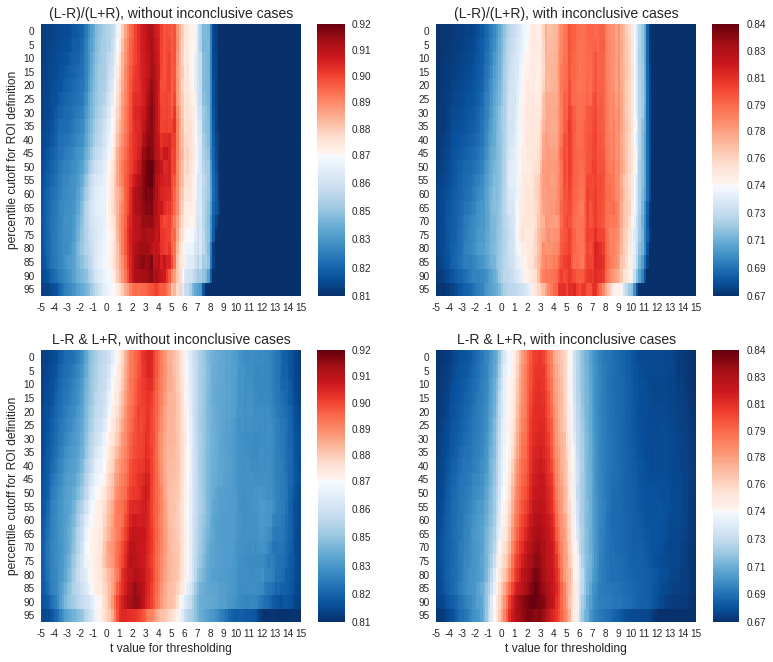

In [41]:
# show accuracies and significance
fig = plt.figure(figsize=(16, 11))
i = 1
for myDim in ['1d', '2d']:
    for myDrop in [True, False]:

        ax = plt.subplot(2, 2, i)
        if myDrop == False:
            l, b, w, h = ax.get_position().bounds
            ax.set_position([l - 0.08, b, w, h])
        myTitle = dTitle1[myDim] + ', ' + dTitle2[myDrop]
        ax.set_title(myTitle, fontsize=14)

        accDf, guessingRate, sigMap, minSig, maxAcc = getForAccPlot(
            myDim, myDrop, my_train)

        print 'dim=%s,drop=%s, guess=%s, sig=%s, acc=%s'%(myDim, myDrop, round(guessingRate,2), round(minSig,2), round(maxAcc,2))

        # set the top value to each pair's highest value, so plots are more
        # comparable

        maxMax = resultDf.loc[:, 'highest accuracy'].loc[dTitle2[myDrop]].max()

        ax = makeAccAx(accDf, guessingRate, sigMap, minSig, maxMax, ax)
        # this is very weird behavior: to get the labels to rotate by 90 degrees,
        # we have to invert their order and rotate them by 360...?
        ax.set_yticklabels(accDf.index[::-1], rotation=360)

        myX = np.concatenate([accDf.columns[::5], np.array([15])])
        ax.set_xticklabels(myX.astype(int), rotation=360)

        if myDim == '2d':
            ax.set_xlabel('t value for thresholding', fontsize=12)

        if myDrop:
            ax.set_ylabel('percentile cutoff for ROI definition', fontsize=12)

        i += 1

fig.savefig(
    '../reports/figures/07-training-feature-accuracy.png',
    dpi=600,
    bbox_inches='tight')

plt.show()